Use the simple SNR model from "Design considerations for low-margin elastic optical networks in the nonlinear regime" Savory et al. with an added white Gaussian noise term, designed to alleviate the problem of significantly reducing the predictive variance of the model:
$SNR = \frac{1}{aP^{-1} + bP^2} + c$, where $a$ and $b$ determine the strength of the linear and nonlinear noise contributions and $c$ represents the TRx NSR.


Demonstrate robustness of the GP model to outlier points by perturbing a randomly chosen point and observing the difference between the physical model-enhanced GP and the standard GP models. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from scipy.optimize import curve_fit
from numpy.random import normal
from simple_model import simple_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
data_dir = '/Users/Kate/physical_gp_josh/physics_enhanced_GPs/pch_sweep_data/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

In [4]:
down_sample_factor = 3  
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])
snr_lin = 10**(snr/10)
pch_lin = 1e-3*10**(pch/10)

In [5]:
len(pch)

13

Select a fraction of the data to use for fitting and another fraction for testing.

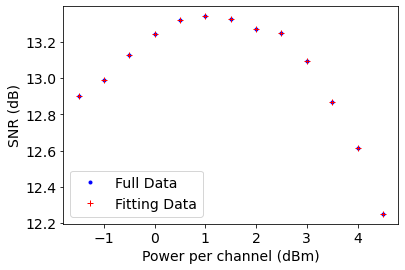

In [6]:
snr_fit = np.copy(snr)[:]
pch_fit = np.copy(pch)[:]
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_fit, snr_fit, 'r+', label='Fitting Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [7]:
sim_model = simple_model()

In [8]:
opt_vals = sim_model.fit(pch.reshape(len(pch),), snr.reshape(len(pch),), init_guess = np.array([1e-5, 1e3, 1e0]))

In [9]:
a_opt, b_opt, c_opt = opt_vals[0]
print(a_opt)
print(b_opt)
print(c_opt)

8.822107559780359e-05
19173.253494589633
11.784028710416118


Parameter 1 std dev estimates

In [10]:
a_opt_err, b_opt_err, c_opt_err = np.sqrt(np.diag(opt_vals[1]))
print(a_opt_err)
print(b_opt_err)
print(c_opt_err)

4.377771987739969e-06
1334.1221357503516
0.46763941431873113


In [11]:
snr_sim = sim_model.predict(pch, a_opt, b_opt, c_opt)
snr_sim_p1 = sim_model.predict(pch, a_opt + a_opt_err, b_opt + b_opt_err, c_opt + c_opt_err)
snr_sim_n1 = sim_model.predict(pch, a_opt - a_opt_err, b_opt - b_opt_err, c_opt - c_opt_err)

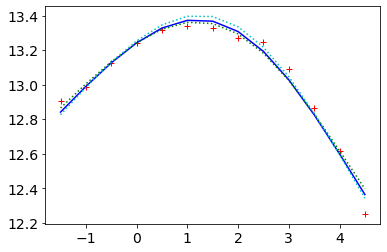

In [12]:
plt.plot(pch, snr, 'r+')
plt.plot(pch, snr_sim, 'b-')
plt.plot(pch, snr_sim_p1, 'g:')
plt.plot(pch, snr_sim_n1, 'c:')
plt.show()

Variation of 1 sigma of the fitted parameters leads to almost no variation in the predictions...

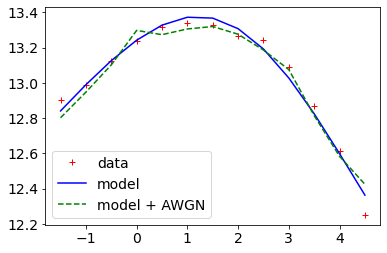

In [13]:
snr_sim_noise = snr_sim.reshape(len(snr_sim),) + np.random.normal(0, 0.03, len(pch))
plt.plot(pch, snr, 'r+', label='data')
plt.plot(pch, snr_sim, 'b-', label='model')
plt.plot(pch, snr_sim_noise, 'g--', label='model + AWGN')
plt.legend()
plt.show()

Fit GP with and without simple physical model and compare results...

In [32]:
num_points_phys = 30 #len(snr)
pch_test = np.linspace(pch[0], pch[-1], num_points_phys).reshape(-1,1) 
#snr_phys_test = sim_model.predict(pch_test, a_opt, b_opt, c_opt).reshape(-1,1)
snr_phys_test = sim_model.predict(pch_test, a_opt, b_opt, c_opt).reshape(len(pch_test),) + np.random.normal(0, 0.03, len(pch_test))
snr_phys_test = snr_phys_test.reshape(-1,1)

Perturb one of the measurements to see the effect on both models. Do this after the physical model parameters have been found.

In [19]:
#np.random.seed()
per_ind = 7 #np.random.randint(0, len(snr))
per_snr = +0.5
snr[per_ind] = snr[per_ind] + per_snr
snr_fit[per_ind] = snr_fit[per_ind] + per_snr

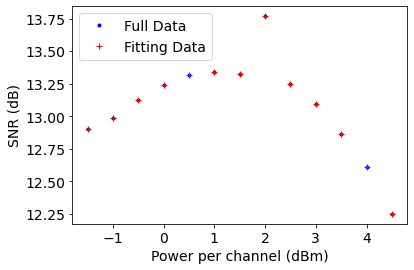

In [20]:
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_fit, snr_fit, 'r+', label='Fitting Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [33]:
pch_fit = pch_fit.reshape(-1, 1)  # needed for SK learn input
#pch_predict = np.linspace(pch_shifted[0], pch_shifted[-1] + 1.0)
pch = pch.reshape(-1,1)
snr_fit = snr_fit.reshape(-1,1)
kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-8,1e5))
gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_phys.fit_phys(pch_fit, pch_test, snr_fit, snr_phys_test)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_phys, std_sk_phys = gpr_phys.predict(pch, return_std=True)
std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
theta_phys = gpr_phys.kernel_.theta
lml_phys = gpr_phys.log_marginal_likelihood()
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [34]:
pch_fit = pch_fit.reshape(-1, 1)  # needed for SK learn input
pch = pch.reshape(-1, 1)  # needed for SK learn input
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-8,1e5))
gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr.fit(pch_fit, snr_fit)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk, std_sk = gpr.predict(pch, return_std=True)
std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
theta = gpr.kernel_.theta
lml = gpr.log_marginal_likelihood()
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

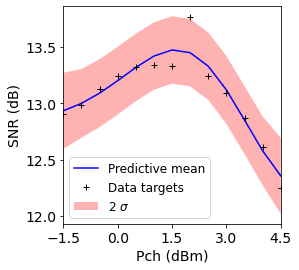

In [35]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b-', label = 'Predictive mean')
ax.plot(pch, snr,'k+', label='Data targets')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xticks([-1.5, 0, 1.5, 3, 4.5])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(prop={'size': 12})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('figures/jlt2021robuststandardGP.pdf', dpi=200,bbox_inches='tight')
plt.show()

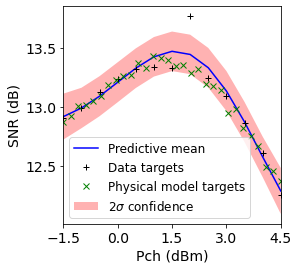

In [36]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk_phys, 'b-', label = 'Predictive mean')
ax.plot(pch, snr,'k+',label='Data targets')
ax.plot(pch_test, snr_phys_test,'gx',label='Physical model targets')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim(pch[0], pch[-1])
plt.xticks([-1.5, 0, 1.5, 3, 4.5])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size': 12})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('figures/jlt2021robustphysGP.pdf', dpi=200,bbox_inches='tight')
plt.show()

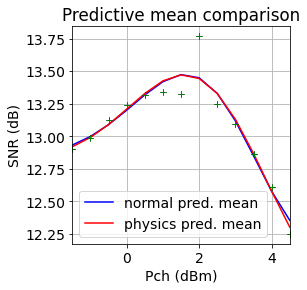

In [25]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b-', label = 'normal pred. mean')
ax.plot(pch, mu_sk_phys, 'r-', label = 'physics pred. mean')
ax.plot(pch, snr,'k+')
ax.plot(pch_fit, snr_fit, 'g+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Predictive mean comparison")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.grid()
f.patch.set_facecolor('w')
plt.savefig('pred_mean_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [29]:
max(std_sk)

array([0.3429891])

In [44]:
max(std_sk_phys)

array([0.17295833])

In [45]:
np.exp(theta)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + W(sigma)

array([4.33289323, 2.35425334, 0.01735402])

In [46]:
np.exp(theta_phys)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + W(sigma)

array([10.60436868,  3.15708008,  0.01222902])

As with the GN model-enhanced GP models, 